# Normalizing Flows

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tomo_challenge import load_data

Found classifier Random
Found classifier ZotBin
Found classifier RandomForest
Found classifier IBandOnly


In [3]:
from zotbin.group import plotfbins
from zotbin.flow import learn_flow

In [4]:
bands='riz'
include_colors=False
include_errors=False

In [5]:
train_file='/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5'
train_data = load_data(train_file, bands, 
                       errors=include_errors,
                       colors=include_colors, array=True)
#train_z = load_redshift(train_file)
print(f'Loaded {len(train_data)} training rows.')

Loaded 5410171 training rows.


/home/dkirkby/DESC/tomo/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


In [24]:
undetected = np.any(train_data == 30, axis=1)
print(f'Removing {np.count_nonzero(undetected)} galaxies with undetected flux in at least one band.')
train_data = train_data[~undetected]

Removing 50677 galaxies with undetected flux in at least one band.


Use r-i, z-i, i as the features:

In [25]:
X = np.concatenate((np.diff(train_data, axis=1), train_data[:, 1:2]), axis=1)

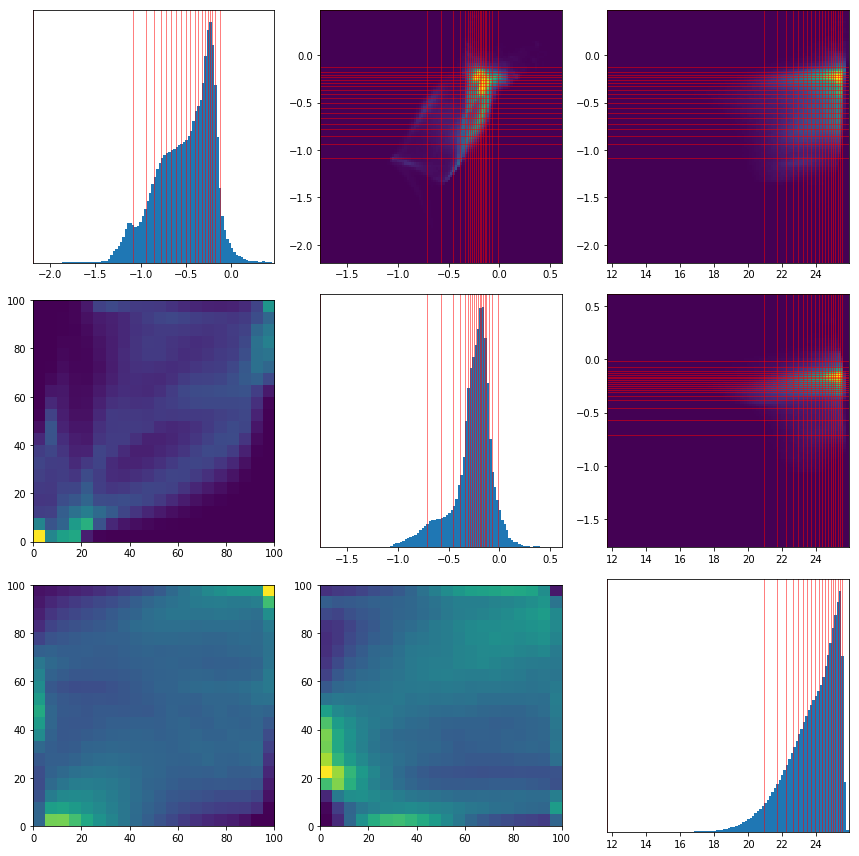

In [26]:
plotfbins(X, inset_pct=0)

epoch 10 loss 3.259


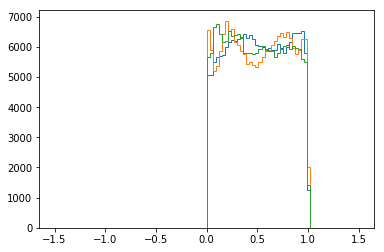

epoch 20 loss 3.236


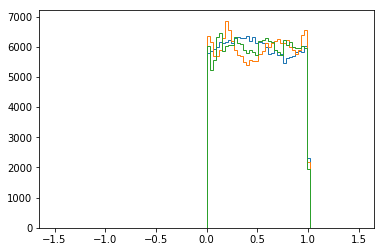

epoch 30 loss 3.263


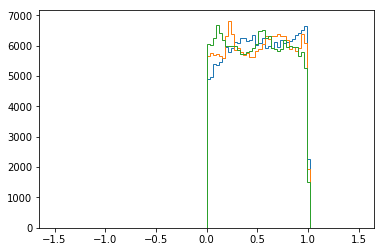

epoch 40 loss 3.287


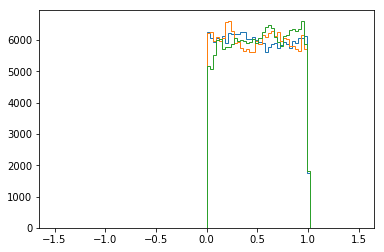

epoch 50 loss 3.256


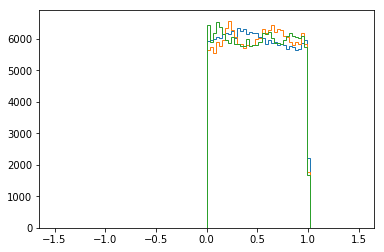

epoch 60 loss 3.288


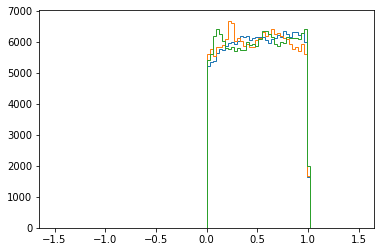

epoch 70 loss 3.336


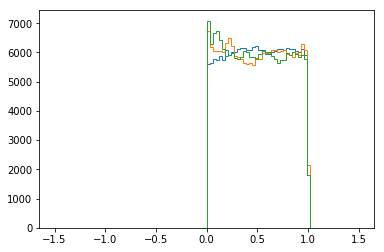

epoch 80 loss 3.219


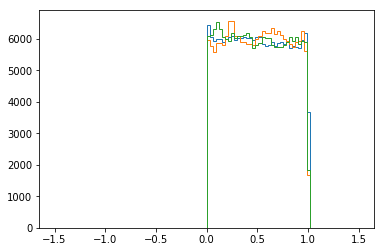

epoch 90 loss 3.249


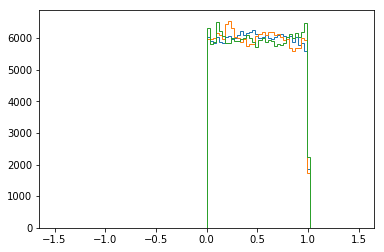

epoch 100 loss 3.225


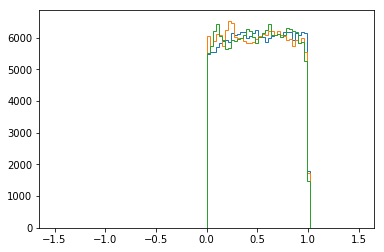

CPU times: user 1min 5s, sys: 2.56 s, total: 1min 8s
Wall time: 32.8 s


In [27]:
%time flow_map = learn_flow(X[:200000], interval=10)

In [28]:
U = flow_map(X)

In [29]:
import scipy.special

In [30]:
U2 = 0.5 * (1 + scipy.special.erf(np.array(U, np.float64) / np.sqrt(2)))

In [31]:
np.all(np.isfinite(U2))

True

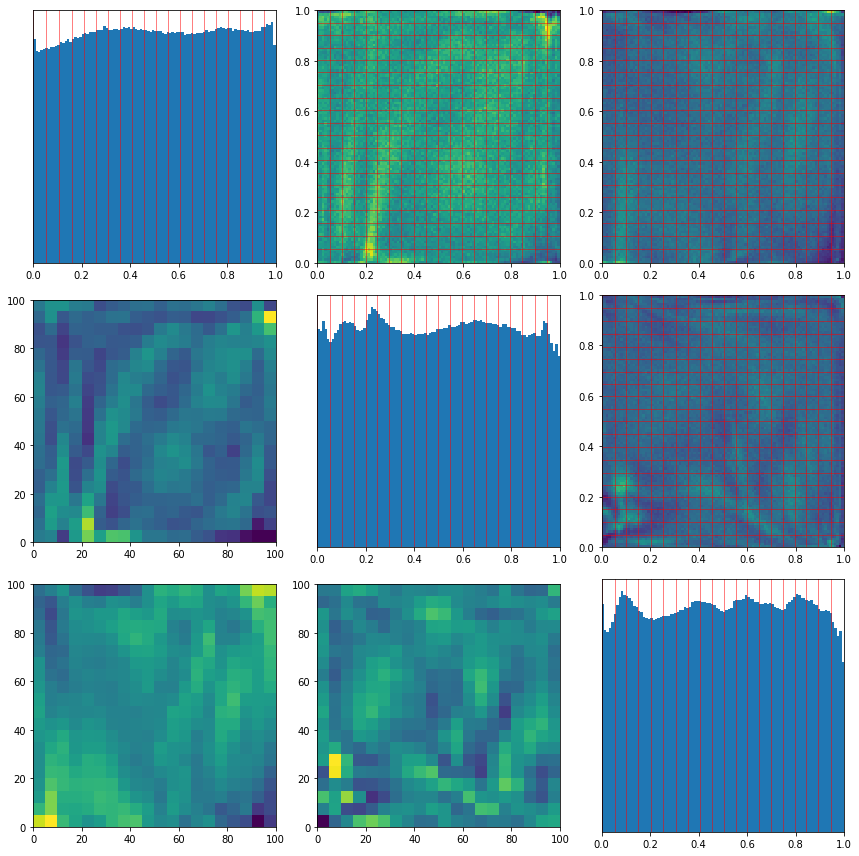

In [32]:
plotfbins(U2, inset_pct=0)